In [44]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq
using BenchmarkTools

In [45]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

u0_CFunction

### Define the system

In [ ]:
# Nbr of particles
N = 10
r = 100 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Size of the box
Lx, Ly, Lz = [1, 1, 1] * 1e-6

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:10;]; # Normalised time

### Compute stationnary state for r repetitions

In [47]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
# Create the directories
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end

In [48]:
# Prepare the function
libpath ="liballfuncs.dll"
f(du, u, params) = ccall(("diffeqf", libpath), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)

f (generic function with 1 method)

In [60]:
popup_SS, popup_t = [], []

@showprogress for i = 1:r
    # Compute distribution
    r0 = [[rand(Float64)*Lx, rand(Float64)*Ly, rand(Float64)*Lz] for i in 1:N]
    # Save the atoms position for comparison with QuantumOptics
    @save "r0/r0_N_$(N)_r_$i.jdl2" r0

    # Normalize the position vectors
    r0 = r0 / λ

    # Plot distribution
    close("all")
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter([r[1] for r in r0], [r[2] for r in r0], [r[3] for r in r0])
    ax.set_xlabel(L"x/$\lambda$"); ax.set_ylabel(L"y/$\lambda$"); ax.set_zlabel(L"z/$\lambda$")
    ax.set_xlim(0, Lx/λ), ax.set_ylim(0, Ly/λ), ax.set_zlim(0, Lz/λ)
    plt.savefig("Images_distribution/Images_distribution_N_$(N)_r_$i")

    # Compute the parameters
    system = SpinCollection(r0, e, gammas=1.)
    Ω_CS = OmegaMatrix(system)
    Γ_CS = GammaMatrix(system)
    Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
    Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
    exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
    conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
    p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

    fsolve(du, u, p, t) = f(du, u, p0)

    ## Compute stationnary state ##
    # Prepare the guess for the steady state
    @load "op_list.jdl2" op_list
    phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4
    uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

    # Compute stationnary state
    prob_ss = SteadyStateProblem(fsolve, uf)
    sol_ss = solve(prob_ss, SSRootfind())
    stationnary_state = sum(real(sol_ss[1:N]))
    push!(popup_SS, stationnary_state)


    ## Compute time evolution ##
    # Prepare the initial state
    phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
    u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

    # Computation
    prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
    sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                reltol=1.0e-6,
                abstol=1.0e-8).u
    push!(popup_t, [sum(real(sol[i][1:N])) for i=1:length(T)])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


# Plots

0.026525602754643662

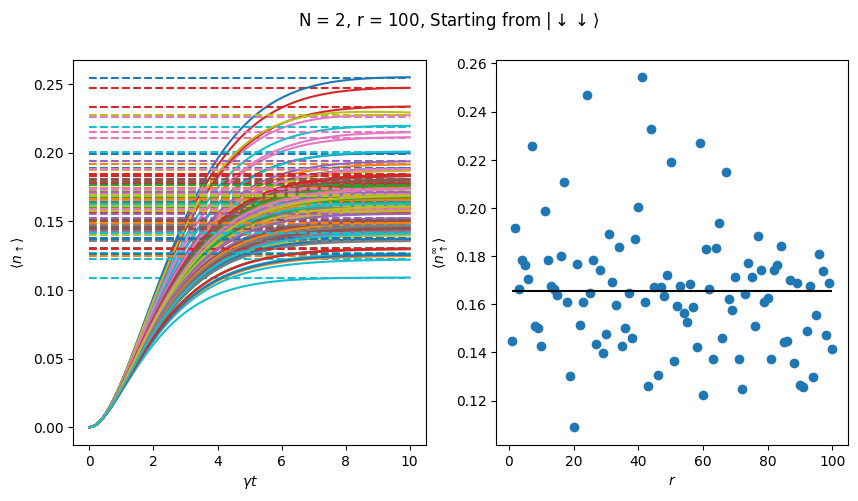

In [61]:
fig, axes = subplots(1, 2, figsize = (10, 5))
for i in 1:r
    line, = axes[1].plot(T, popup_t[i])
    axes[1].hlines(popup_SS[i], T[1], T[end], linestyle="--", color = line.get_color())
end
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

axes[2].scatter([1:r], popup_SS)
axes[2].hlines(mean(popup_SS), 1, r, color="black")
axes[2].set_xlabel(L"r")
axes[2].set_ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
print(std(popup_SS))

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

### Stats on distance between atoms

In [110]:
argmax(popup_SS)

41

In [87]:
d0 = zeros(r, N, N) # repetiton, atom i, distance from atom j
for i = 1:r
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0
    r0 = r0/λ # Normalisation
    for j in 1:N
        for k = 1:N
            d0[i, j, k] = norm(r0[j]-r0[k])
        end
    end
end

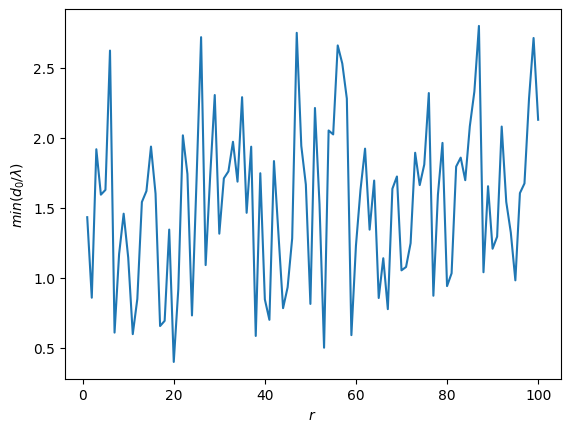

In [111]:
close("all")
figure()
plot([1:r;], [minimum(d0[i, :, :][d0[1, :, :] .> 0]) for i = 1:r])
xlabel(L"r")
ylabel(L"min(d_0/\lambda)")
pygui(false); gcf()